In [2]:
!pip install tflearn

     |████████████████████████████████| 112kB 5.1MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-cp37-none-any.whl size=127301 sha256=04050a1367bdb23c1a7fa02d9c354c9928cf6d8855f58691349a38579832a97c
  Stored in directory: /root/.cache/pip/wheels/31/d2/ed/fb9a0d301dd9586c11e9547120278e624227f22fd5f4baf744
Successfully built tflearn


In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_curve,recall_score,precision_score,f1_score,auc,confusion_matrix

import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,MaxPool2D,GlobalMaxPooling2D
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

import tflearn.datasets.oxflower17 as oxflower17

tf.__version__

'2.4.1'

In [4]:
seed = 123
np.random.seed(seed)

# Import the data. Analyse the dimensions of the data

In [5]:
x, y = oxflower17.load_data(one_hot=True)

100.0% 60276736 / 60270631


Succesfully downloaded 17flowers.tgz 60270631 bytes.
File Extracted
Starting to parse images...
Parsing Done!


In [6]:
print("Image shape" ,x.shape)
print("Target class shape" ,y.shape)

Image shape (1360, 224, 224, 3)
Target class shape (1360, 17)


In [11]:
img_width = 224
img_height = 224

# Data visualisation

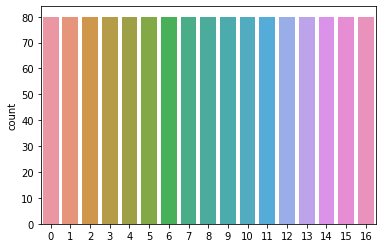

In [7]:
sns.countplot(x=y.argmax(axis=1))

Observation - Samples for all the class (0 -17) are distributed uniform  

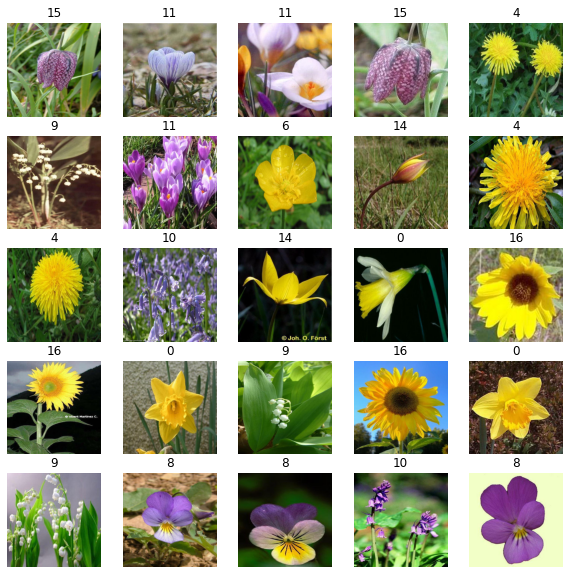

In [8]:
labels = y.argmax(axis=1)

fig=plt.figure(figsize=(10,10))
columns=5
rows=5
for i in range(1, columns*rows+1):
    img=x[i]
    fig.add_subplot(rows,columns,i)
    plt.imshow(img)
    plt.title(labels[i])
    plt.axis('off')
plt.show()

# applying filters for the image

Kernal Size -  5


<Figure size 720x720 with 0 Axes>

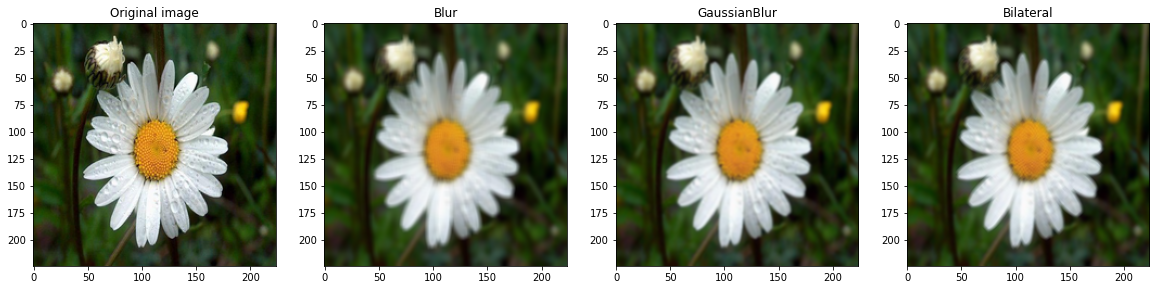

Kernal Size -  7


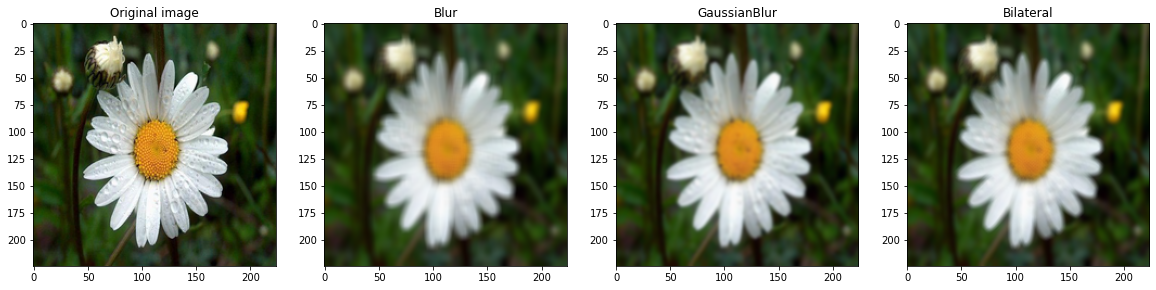

Kernal Size -  11


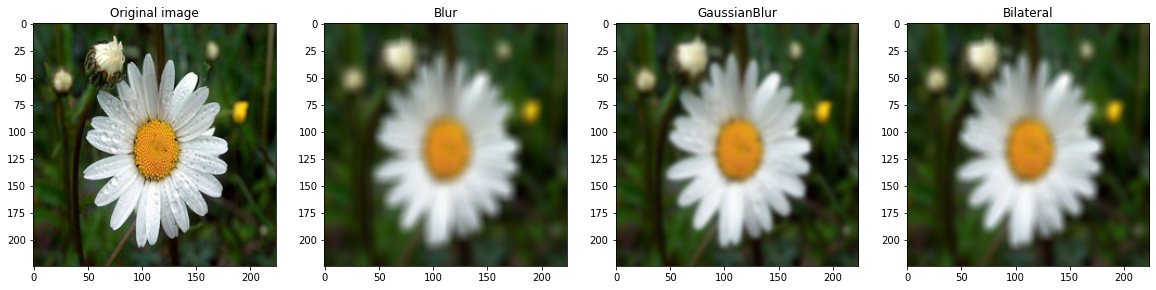

Kernal Size -  5


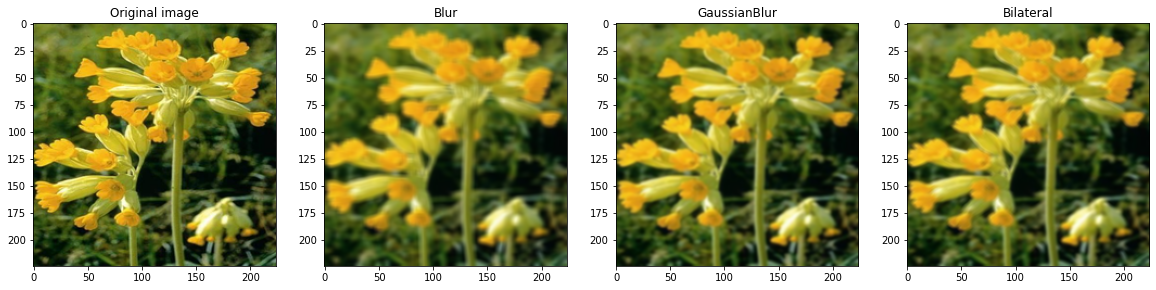

Kernal Size -  7


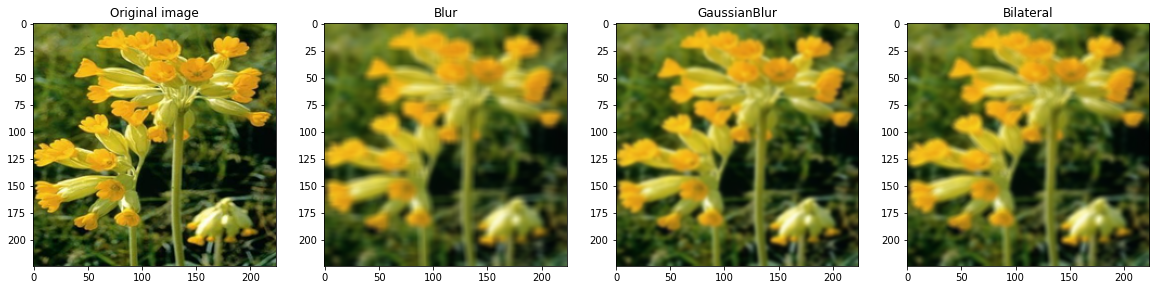

Kernal Size -  11


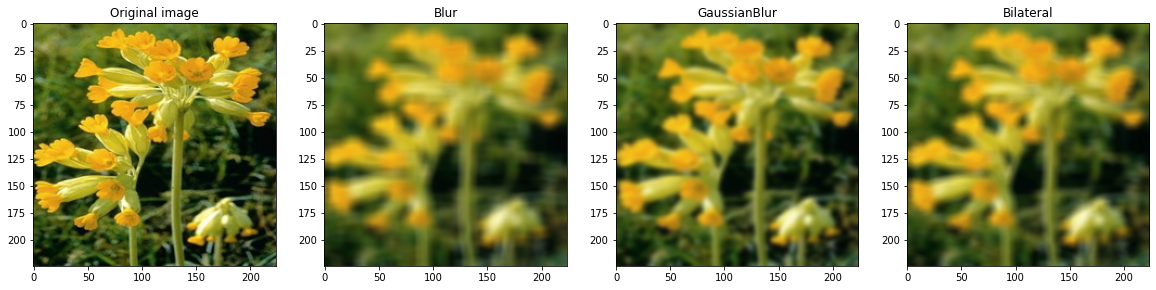

In [9]:
kernal_size_list = [5,7,11]
fig=plt.figure(figsize=(10,10))
columns=5
rows=5


def plot_img(images,title):
  fig, axs = plt.subplots(nrows = 1, ncols = len(images),
                          figsize = (20, 20))
  index = 0
  for img in images:
        axs[index].imshow(img)
        axs[index].set_title(title[index])
        index = index +1
       
  plt.show()



for index in range(2):
    image_index = np.random.randint(0,1360)
    for kernal in kernal_size_list:
            print( "Kernal Size - ",kernal)
            img=x[image_index]
            a_img = cv2.blur(img,(kernal,kernal))
            g_img = cv2.GaussianBlur(img,(kernal,kernal),0)
            b_img = cv2.bilateralFilter(img,kernal,75,75)

            plot_img([img,a_img,g_img,b_img],["Original image","Blur","GaussianBlur","Bilateral"])



# Training Model

In [12]:
# data split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=123)

## Normalize 
X_train = X_train /  255
X_test = X_test /  255

print("X_train min / max ", X_train.min(),X_train.max())
print("X_test min / max ", X_test.min(),X_test.max())

X_train_svc = X_train.reshape(X_train.shape[0],3*img_width*img_height)
print("X_train_svc data shape ", X_train_svc.shape)

X_test_svc= X_test.reshape(X_test.shape[0],3*img_width*img_height)
print("X_train_svc data shape ", X_test_svc.shape)

y_train_svc = y_train.argmax(axis=1)
print("y_train_svc data shape ", y_train_svc.shape)

y_test_svc = y_test.argmax(axis=1)
print("y_test_svc data shape ", y_test_svc.shape)


print("X_train data shape ", X_train.shape)
print("y_train data shape ", y_train.shape)

print("X_test data shape ", X_test.shape)
print("y_test data shape ", y_test.shape)



X_train min / max  0.0 0.003921569
X_test min / max  0.0 0.003921569
X_train_svc data shape  (952, 150528)
X_train_svc data shape  (408, 150528)
y_train_svc data shape  (952,)
y_test_svc data shape  (408,)
X_train data shape  (952, 224, 224, 3)
y_train data shape  (952, 17)
X_test data shape  (408, 224, 224, 3)
y_test data shape  (408, 17)


In [13]:
%%time

pca = PCA(0.95)
estimator = SVC(kernel="rbf")
param_grid = {}
pipe = Pipeline(steps=[('pca', pca), ('estimator', estimator)])
gridsearch = GridSearchCV(pipe, param_grid, n_jobs=-1)

gridsearch.fit(X_train_svc,y_train_svc)
y_predict = gridsearch.predict(X_test_svc)

CPU times: user 1min 37s, sys: 9.62 s, total: 1min 47s
Wall time: 4min 16s


train_score 0.92
test_score 0.42


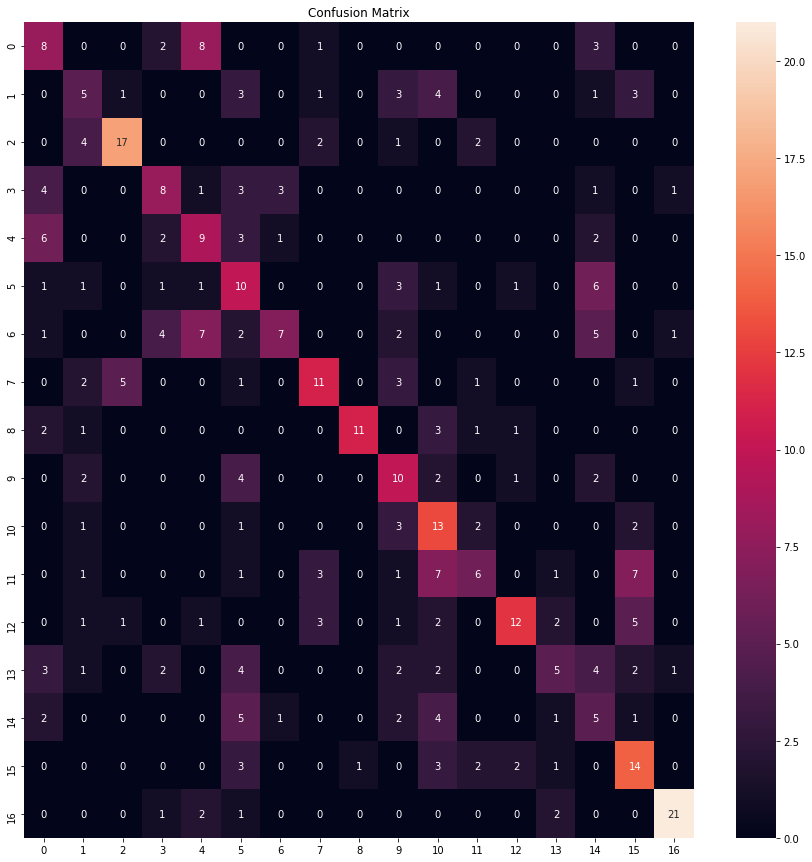

In [15]:
print("train_score" , round(gridsearch.score(X_train_svc,y_train_svc),2))
print("test_score", round(gridsearch.score(X_test_svc,y_test_svc),2))


np.set_printoptions(precision=3)
fig, ax = plt.subplots(figsize=(15,15))
cm = confusion_matrix(y_test_svc,y_predict)
sns.heatmap(cm, annot=True, ax=ax)
ax.set_title('Confusion Matrix'); 


# Nural Network

In [24]:
def nn_model_dropout(kernel_initializer = "normal"):
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(387, activation = "relu"))   
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation = "relu"))   
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(17, activation = "softmax"))
    return model


model_drop = nn_model_dropout(kernel_initializer="normal")
optimizer = SGD(lr=0.001, momentum=0.9)

es = EarlyStopping(monitor='val_loss', patience=10,min_delta=0.05)
model_drop.compile(optimizer = optimizer, loss = 'categorical_crossentropy', 
                   metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)



fit_data = model_drop.fit(X_train, y_train, validation_data=(X_test,y_test),
                           batch_size = 32, epochs = 100, verbose = 1,callbacks=[es])

Train on 952 samples, validate on 408 samples
Epoch 1/100
952/952 [==============================] - 10s 11ms/sample - loss: 2.5386 - acc: 0.2132 - val_loss: 2.8199 - val_acc: 0.0760
Epoch 2/100
952/952 [==============================] - 9s 10ms/sample - loss: 1.7543 - acc: 0.4391 - val_loss: 2.8129 - val_acc: 0.1691
Epoch 3/100
952/952 [==============================] - 9s 10ms/sample - loss: 1.3773 - acc: 0.5945 - val_loss: 2.8040 - val_acc: 0.1961
Epoch 4/100
952/952 [==============================] - 9s 10ms/sample - loss: 1.0706 - acc: 0.7038 - val_loss: 2.7984 - val_acc: 0.1201
Epoch 5/100
952/952 [==============================] - 9s 10ms/sample - loss: 0.8740 - acc: 0.7721 - val_loss: 2.7830 - val_acc: 0.1495
Epoch 6/100
952/952 [==============================] - 9s 10ms/sample - loss: 0.6904 - acc: 0.8561 - val_loss: 2.7740 - val_acc: 0.0858
Epoch 7/100
952/952 [==============================] - 9s 10ms/sample - loss: 0.5557 - acc: 0.8918 - val_loss: 2.7504 - val_acc: 0.1569
E

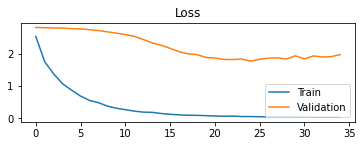

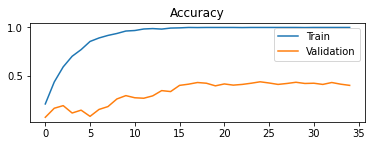

In [27]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(fit_data.history['loss'],label="Train")
plt.plot(fit_data.history['val_loss'],label="Validation")
plt.legend()
plt.show()

# plot loss during training
plt.subplot(211)
plt.title('Accuracy')
plt.plot(fit_data.history['acc'],label="Train")
plt.plot(fit_data.history['val_acc'],label="Validation")

plt.legend()
plt.show()

In [35]:
#The idea is to alter the training data with small transformations
datagen = ImageDataGenerator(
        shear_range = 0.2,zoom_range = 0.2,horizontal_flip = True)
        

datagen.fit(X_train)

def cnn_model():
    model = Sequential()

    # Add a Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
    model.add(Conv2D(32, (5, 5), input_shape = (img_width, img_height, 3), activation = 'relu', padding = 'same'))

    # Add a Max Pooling layer of size 2X2
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
    model.add(Conv2D(32, (5, 5), activation = 'relu', padding = 'same'))

    # Adding another pooling layer
    model.add(MaxPooling2D(pool_size = (2, 2)))

    # Add another Convolution layer with 32 kernels of 3X3 shape with activation function ReLU
    model.add(Conv2D(32, (5, 5), activation = 'relu', padding = 'same'))

    # Adding another pooling layer
    model.add(MaxPooling2D(pool_size = (2, 2)))

    model.add(Flatten())
    model.add(Dense(387, activation = "relu"))   
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(64, activation = "relu"))   
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    model.add(Dense(17, activation = "softmax"))
    return model


cnn_model = cnn_model()
optimizer = SGD(learning_rate=0.001,momentum=0.9)
cnn_model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train.argmax(axis=1)),
                                                 y_train.argmax(axis=1))
class_weights_dict = dict(zip(np.unique(y_train.argmax(axis=1)), class_weights))

es = EarlyStopping(monitor='val_loss', patience=5,min_delta=0.01)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

cnn_fit_data = cnn_model.fit_generator(datagen.flow(X_train,y_train, batch_size=32),
                              epochs = 500, validation_data = (X_test,y_test)
                                       ,steps_per_epoch = int(952/32)
                                       ,validation_steps = int(408/32)                                       
                              ,callbacks=[es,learning_rate_reduction])



Epoch 1/500
29/29 [==============================] - 129s 4s/step - batch: 14.0000 - size: 31.7241 - loss: 2.8341 - acc: 0.0924 - val_loss: 7.8517 - val_acc: 0.0564
Epoch 2/500
29/29 [==============================] - 126s 4s/step - batch: 14.0000 - size: 31.7241 - loss: 2.7987 - acc: 0.1163 - val_loss: 16.2855 - val_acc: 0.0515
Epoch 3/500
29/29 [==============================] - 126s 4s/step - batch: 14.0000 - size: 31.7241 - loss: 2.7118 - acc: 0.1522 - val_loss: 45.2416 - val_acc: 0.0515
Epoch 4/500
29/29 [==============================] - ETA: 0s - batch: 14.0000 - size: 31.7241 - loss: 2.7933 - acc: 0.1348
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
29/29 [==============================] - 126s 4s/step - batch: 14.0000 - size: 31.7241 - loss: 2.7933 - acc: 0.1348 - val_loss: 94.2368 - val_acc: 0.0515
Epoch 5/500
29/29 [==============================] - 126s 4s/step - batch: 14.0000 - size: 31.7241 - loss: 2.8196 - acc: 0.1413 - val_loss: 137.62